In [1]:
pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 15.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 1.34.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 4.25.6 which is incompatible.
google-spark-connect 0.5.2 requires google-api-core>=2.19.1, but you have google-api-core 1.34.1 which is incompatible.
pandas-gbq 0.26.1 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is

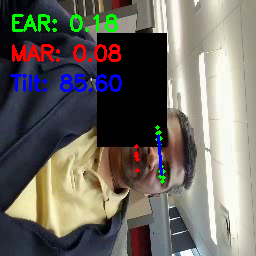


✅ Done! Processed 35 videos. Skipped: 1.
📄 Saved CSV: /kaggle/working/combined_dataset.csv
⏱️ Total Time: 1659.04s


In [2]:
import cv2
import mediapipe as mp
import numpy as np
import csv
import os
import time
from google.colab.patches import cv2_imshow
from IPython.display import clear_output

# === MediaPipe Face Mesh Setup ===
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=False,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

# === EAR Calculation ===
def compute_EAR(landmarks, w, h, indices):
    coords = [(int(landmarks.landmark[i].x * w), int(landmarks.landmark[i].y * h)) for i in indices]
    A = np.linalg.norm(np.array(coords[1]) - np.array(coords[5]))
    B = np.linalg.norm(np.array(coords[2]) - np.array(coords[4]))
    C = np.linalg.norm(np.array(coords[0]) - np.array(coords[3]))
    return (A + B) / (2.0 * C)

# === MAR Calculation ===
def compute_MAR(landmarks, w, h, indices):
    coords = [(int(landmarks.landmark[i].x * w), int(landmarks.landmark[i].y * h)) for i in indices]
    vertical = np.linalg.norm(np.array(coords[2]) - np.array(coords[3]))
    horizontal = np.linalg.norm(np.array(coords[0]) - np.array(coords[5]))
    return vertical / horizontal

# === Head Tilt Calculation ===
def compute_head_tilt(landmarks, w, h, left_indices, right_indices):
    left = [(landmarks.landmark[i].x * w, landmarks.landmark[i].y * h) for i in left_indices]
    right = [(landmarks.landmark[i].x * w, landmarks.landmark[i].y * h) for i in right_indices]
    left_center = np.mean(left, axis=0).astype(int)
    right_center = np.mean(right, axis=0).astype(int)
    delta_y = right_center[1] - left_center[1]
    delta_x = right_center[0] - left_center[0]
    angle = np.degrees(np.arctan2(delta_y, delta_x))
    return angle, left_center, right_center

# === Extract Label from Filename ===
def extract_label_from_filename(filename):
    if "_0" in filename:
        return 0
    elif "_5" in filename:
        return 5
    elif "_10" in filename:
        return 10
    else:
        return -1

# === Process One Video ===
def process_video(video_path, show_preview=True):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    output_data = []

    label = extract_label_from_filename(video_path)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1
        h, w = frame.shape[:2]
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(rgb_frame)

        if results.multi_face_landmarks:
            landmarks = results.multi_face_landmarks[0]

            left_eye = [33, 160, 158, 133, 153, 144]
            right_eye = [263, 387, 385, 362, 380, 373]
            mouth = [78, 308, 13, 14, 82, 312]

            ear_left = compute_EAR(landmarks, w, h, left_eye)
            ear_right = compute_EAR(landmarks, w, h, right_eye)
            ear = (ear_left + ear_right) / 2.0

            mar = compute_MAR(landmarks, w, h, mouth)
            head_tilt, left_center, right_center = compute_head_tilt(landmarks, w, h, left_eye, right_eye)

            # Draw eye landmarks
            for idx in left_eye + right_eye:
                x = int(landmarks.landmark[idx].x * w)
                y = int(landmarks.landmark[idx].y * h)
                cv2.circle(frame, (x, y), 2, (0, 255, 0), -1)

            # Draw mouth landmarks
            for idx in mouth:
                x = int(landmarks.landmark[idx].x * w)
                y = int(landmarks.landmark[idx].y * h)
                cv2.circle(frame, (x, y), 2, (0, 0, 255), -1)

            # Draw line between eyes
            cv2.line(frame, tuple(left_center), tuple(right_center), (255, 0, 0), 2)

            # Overlay text
            cv2.putText(frame, f"EAR: {ear:.2f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            cv2.putText(frame, f"MAR: {mar:.2f}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            cv2.putText(frame, f"Tilt: {head_tilt:.2f}", (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

            output_data.append([os.path.basename(video_path), frame_count, ear, mar, head_tilt, label])

            if show_preview and frame_count % 60 == 0:
                clear_output(wait=True)
                cv2_imshow(frame)

    cap.release()
    return output_data

# === Process Folder ===
def process_folder(folder_path, output_csv_path):
    all_data = []
    file_count = 0
    skipped = 0
    start_time = time.time()

    for filename in os.listdir(folder_path):
        if filename.endswith(".mp4"):
            full_path = os.path.join(folder_path, filename)
            if filename == "37_0_mov.mp4":
                print(f"⏭️ Skipping file: {filename}")
                skipped += 1
                continue

            print(f"🎞️ Processing: {filename}")
            video_data = process_video(full_path)
            all_data.extend(video_data)
            file_count += 1

    # Save to CSV
    with open(output_csv_path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['video', 'frame', 'EAR', 'MAR', 'Head_Tilt', 'Label'])
        writer.writerows(all_data)

    print(f"\n✅ Done! Processed {file_count} videos. Skipped: {skipped}.")
    print(f"📄 Saved CSV: {output_csv_path}")
    print(f"⏱️ Total Time: {time.time() - start_time:.2f}s")

# === Run It ===
folder_path = "/kaggle/input/new-start/mp4_data_augmented/"
output_csv = "/kaggle/working/combined_dataset.csv"
process_folder(folder_path, output_csv)


In [3]:
import pandas as pd

# Load the CSV
df = pd.read_csv('/kaggle/input/combined-csv/combined_dataset.csv')

# Filter out extreme head tilt values
df_filtered = df[(df['Head_Tilt'] <= 50) & (df['Head_Tilt'] >= -50)]

# Save the cleaned CSV
df_filtered.to_csv('/kaggle/working/filtered_combined_dataset.csv', index=False)

print(f"✅ Filtered dataset saved! Original: {len(df)}, After Filtering: {len(df_filtered)} rows.")


✅ Filtered dataset saved! Original: 217427, After Filtering: 178977 rows.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-16 22:15:33.715351: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/30
4475/4475 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.4842 - loss: 1.0142 - val_accuracy: 0.5825 - val_loss: 0.8919
Epoch 2/30
4475/4475 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.5507 - loss: 0.9262 - val_accuracy: 0.5855 - val_loss: 0.8776
Epoch 3/30
4475/4475 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.5615 - loss: 0.9149 - val_accuracy: 0.5927 - val_loss: 0.8698
Epoch 4/30
4475/4475 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.5627 - loss: 0.9114 - val_accuracy: 0.5955 - val_loss: 0.8678
Epoch 5/30
4475/4475 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.5691 - loss: 0.9046 - val_accuracy: 0.5941 - val_loss: 0.8659
Epoch 6/30
4475/4475 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.5718 - loss: 0.8999 - val_accuracy: 0.5965 - val_loss: 0.8640
Epoch 7/30
4475/4475 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.5732 - loss: 0.8972 - val_accuracy: 0.5975 - val_loss: 0.8618
Epoch 8/30
4475/4475 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.5762 - loss: 0

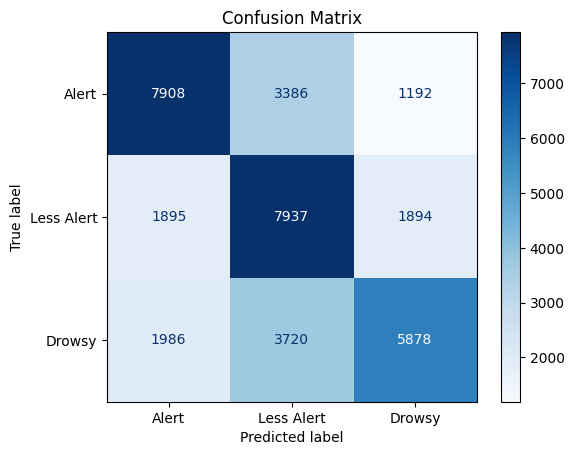


Classification Report:

              precision    recall  f1-score   support

       Alert       0.67      0.63      0.65     12486
  Less Alert       0.53      0.68      0.59     11726
      Drowsy       0.66      0.51      0.57     11584

    accuracy                           0.61     35796
   macro avg       0.62      0.61      0.61     35796
weighted avg       0.62      0.61      0.61     35796

Model saved at /kaggle/working/alertness_model.h5


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# === 1. Load dataset ===
df = pd.read_csv("/kaggle/input/filtered-data/filtered_combined_dataset.csv")

# Features and labels
X = df[['EAR', 'MAR', 'Head_Tilt']].values
y = df['Label'].values

# === 2. Normalize features ===
scaler = StandardScaler()
X = scaler.fit_transform(X)

# === 3. Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# === 4. Class weights (to balance training) ===
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(weights))

# === 5. Shift label values for one-hot encoding (0, 5, 10 -> 0, 1, 2) ===
y_train_shifted = np.where(y_train == 0, 0, np.where(y_train == 5, 1, 2))
y_test_shifted = np.where(y_test == 0, 0, np.where(y_test == 5, 1, 2))

# === 6. One-hot encode the labels for DNN ===
y_train_cat = to_categorical(y_train_shifted, num_classes=3)
y_test_cat = to_categorical(y_test_shifted, num_classes=3)

# === 7. Define DNN model ===
model = Sequential([
    Dense(128, activation='relu', input_shape=(3,)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])

# === 8. Compile model ===
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# === 9. Train the model ===
history = model.fit(
    X_train, y_train_cat,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test_cat),
    class_weight=class_weights,
    verbose=1
)

# === 10. Evaluate ===
loss, accuracy = model.evaluate(X_test, y_test_cat)
print(f"\nTest Accuracy: {accuracy:.2f}")

# === 11. Confusion matrix & classification report ===
y_pred = model.predict(X_test).argmax(axis=1)
cm = confusion_matrix(y_test_shifted, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Alert', 'Less Alert', 'Drowsy'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# === 12. Print classification report ===
print("\nClassification Report:\n")
print(classification_report(y_test_shifted, y_pred, target_names=['Alert', 'Less Alert', 'Drowsy']))


model.save('/kaggle/working/alertness_model.h5')
print("Model saved at /kaggle/working/alertness_model.h5")